# Extract Real WFC3/IR G102 Data

This notebook shows how to extract WFC3/IR data from G102.  The data have been taken from the FIGS program (PI: S. Malhotra, prop ID: 13779 at https://archive.stsci.edu/proposal_search.php?id=13779&mission=hst).  

These data have been significantly pre-processed to prepare them for ```pyLINEAR```, namely the key steps are:

1. **Astrometric Refinement**: These data (as with most grism data) were taken with contemporaneous pre-imaging in an imaging filter whose transmission is similar to the grism (in this case F105W was used) to refine the WCS information in the grism data.  In brief, the positions of sources were measured in the shallow F105W pre-imaging to derive tweaks to the pre-imaging WCS based on the larger and deeper GOODS mosaics.  These tweaks are blindly applied to the grism data, since the observations occurred in the visit with the same guide stars.  
2. **Background Subtraction**: All grism data require some type of background subtraction and so recall: since the sky background has a given spectrum (which gets dispersed by the grism), it will have a characteristic *structure* in the 2d grism images.  Therefore, the method developed for ACS (G800L) was to use a collection of grism images to determine the overall shape of the optical sky background and scale this resultant image to reproduce the background seen in a given image.  This "master sky" technique is extended for WFC3/IR, where there are multiple background components (e.g. zodiacal light, He I emission, etc.) that vary on timescales approaching the sample time.  Please see [Pirzkal & Ryan (2020)](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2020/WFC3_IR_2020-04.pdf) for more detail on this.

The FIGS data were taken at five orients with 8 orbits (32 exposures) per orient.  For brevity's sake, we will be looking at 10 exposures, two from each orient of the Hubble Ultra-Deep Field and the corresponding direct image (in F105W) and segmentation map (derived from a complex procedure).  Please see [Pirzkal et al. (2017)](https://ui.adsabs.harvard.edu/abs/2017ApJ...846...84P/abstract) for details on the reduction, cataloging, and other useful information.   Please download the file: ```pylinear_test_data.tar.gz``` data from:

[https://stsci.box.com/s/wjh9v8h3lvlygrfe0v4rbzvnhom3t1qq](https://stsci.box.com/s/wjh9v8h3lvlygrfe0v4rbzvnhom3t1qq)

Unpack the data in the current working directory, and then we can proceed.  Or you can laboriously download each file individually.

*These data are kindly provided by N. Pirzkal for testing of ```pyLINEAR```.*



In [1]:
import pylinear
import numpy as np
from astropy.io import fits
import glob
import matplotlib.pyplot as plt

info> Loading source catalog
info> Loading an observational catalog
debug> implement source filtering
info> Loading sources from CLASSIC segmentation map
info> Loading broadband photometry
info> Loaded 9 sources
info> Loading grism collection
info> Loading observed grism images
info> Loaded 10 images
info> updating extraction parameters.
info> Starting the group algorithm
info> Grouping the IDs
info> Grouping the IDs
info> Grouping the IDs
info> Grouping the IDs
info> Grouping the IDs
info> Grouping the IDs
info> Grouping the IDs
info> Grouping the IDs
info> Grouping the IDs
info> Grouping the IDs
info> Grouping the IDs
info> Done grouping. Found 9 groups.

info> Building the matrix: 10 images, 1 sources.
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug>

info> Building the matrix: 10 images, 1 sources.
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
debug> Look into wedge offsets
info> Compressing the indices
info> Building a damping target
info> Running LSQR with l=0.03186193314036514
info> Running LSQR with l=0.44583088983369035
info> Running LSQR with l=2.2770579755471743
info> Running LSQR with l=31.86193314036514
info> Running LSQR with l=6.238327770454366
info> Running LSQR with l=11.629954635797375

debug> Look into wedge offsets
debug> Look into wedge offsets
alarm> Matrix has no elements.
alarm> Matrix has no elements. Cannot set damping target.
alarm> Matrix has no elements.


In [2]:
segfile = 'GS1_-35_seg_new.fits'
obslst  = 'obs_figs.lst'
imglst  = 'flt_figs.lst'
beam    = '+1'
mskbeam = '+2'
path    = 'tables_figs'
method  = 'golden'
maglim  = 19.                         # the segmap isn't deep, but lets be more restrictive for time
logdamp = [-4,-1,0.1]
root    = 'figs'
progid  = 'coi'                       # program ID for FIGS

### Step 1. Load the Data.
At this point, we've seen how to do simple- and composite-source extractions with ```pyLINEAR```.  Therefore the simple-extraction described here should be familiar.  But real data has a few minor changes, so stay tuned.

In [4]:
# step 1a. make an observations file
with open(obslst,'w') as fp:
    print('GS1_-35_f105w_g_ref.fits  hst_wfc3_f105w',file=fp)

# step 1b. load the sources    
sources = pylinear.source.SourceCollection(segfile,obslst,detindex=0,maglim=maglim)

# step 1c. make an FLT lst
with open(imglst,'w') as fp:
    for f in glob.glob('i{}*flt.fits'.format(progid)):
        print(f,file=fp)

# step 1d. Load the grism images        
grisms = pylinear.grism.GrismCollection(imglst,observed=True)

# step 1e. set the default ranges
extraction_parameters = grisms.get_default_extraction()
sources.update_extraction_parameters(*extraction_parameters)

  4292: 100%|██████████| 20/20 [00:00<00:00, 54.29it/s]


### Step 2. Compute the Pixel tables
For the simulations, we didn't bother with ***object-mask tables*** (OMT), but for the real data, we do need to worry a bit.  So there are two steps here, one just like before and now one for masking.  

***This step will be slow, so be patient.***

In [6]:
# step 2a. compute the pixel tables for the beam to extract
tabulate = pylinear.modules.Tabulate('pdt',path=path,ncpu=0)   # note the ncpu = 0
tabnames = tabulate.run(grisms,sources,beam)

# step 2b. make mask tables for the beam to mask
#          could create a new tabulate object, or just reuse the old one.  For the 
#          latter, we need to change some of the internal settings:
tabulate.ttype = 'omt'
tabulate.nsub = 1
msknames = tabulate.run(grisms,sources,mskbeam)

### Step 3. Do the Extraction
By and large, this should be exactly as before.  However, we need to specify the optional argument ```mskbeams``` to mask certain beams. 

This step will be slow for two reasons:

1.  we are grouping the sources (which is usually not too bad), but is a step that was skipped before.
2.  the extraction is a bit slower with ~20 very birght (ie. large) galaxies.

***So be patient.***

In [5]:
# step 3. do the extraction
pylinear.modules.extract.extract1d(grisms,sources,beam,logdamp,method,root,path,mskbeams=mskbeam)

Loading ODTs: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


### Step 4 (optional).  Inspect the Results

As before, ***always*** check the ```_lcv.pdf``` file.  This is a front-line defense to identifying problems.  In previous examples, we looked at ```method='grid'``` and so the sampling in the ```lcv.pdf``` file was regular.  Now, with ```method='golden'```, the sampling will be far more irregular and sparse away from the solution - this is to be expected.  However, it is still important to verify that things make sense.  Also, there are more pages to the ```lcv.pdf``` file --- recall there is one page for each group.  We did not group in the previous example.

Let's plot a ```pyLINEAR``` extraction with the published FIGS spectrum, however there are some cautionary remarks:

1.  The FIGS spectrum was taken with 16x more data, so the signal-to-noise should be much higher and potentially slightly different.  Therefore, we are just looking for broad agreement.
2.  We only extracted things *BRIGHTER* than 19 mag, which is very few sources (we did this to reduce the CPU time).  The galaxy we will look at is contaminted by fainter sources (which is non-negligible), and the released FIGS spectra have been *contamination corrected*.  Although ```pyLINEAR``` solves the full system of linear equations, we did not account for the faint galaxies by stopping the catalog at ```maglim=19```.  Therefore, we will ***uncorrect*** the FIGS spectra to compare with ```pyLINEAR```.
3.  Because FIGS was extracted with a tailored version of ```aXe```, the philosophy was to extract each orient separately and provide them to the community.  We combined the multiple orients *after* the contamination was estimated and subtracted. But based on the previous item, this notebook will need to propagate the separate orients.


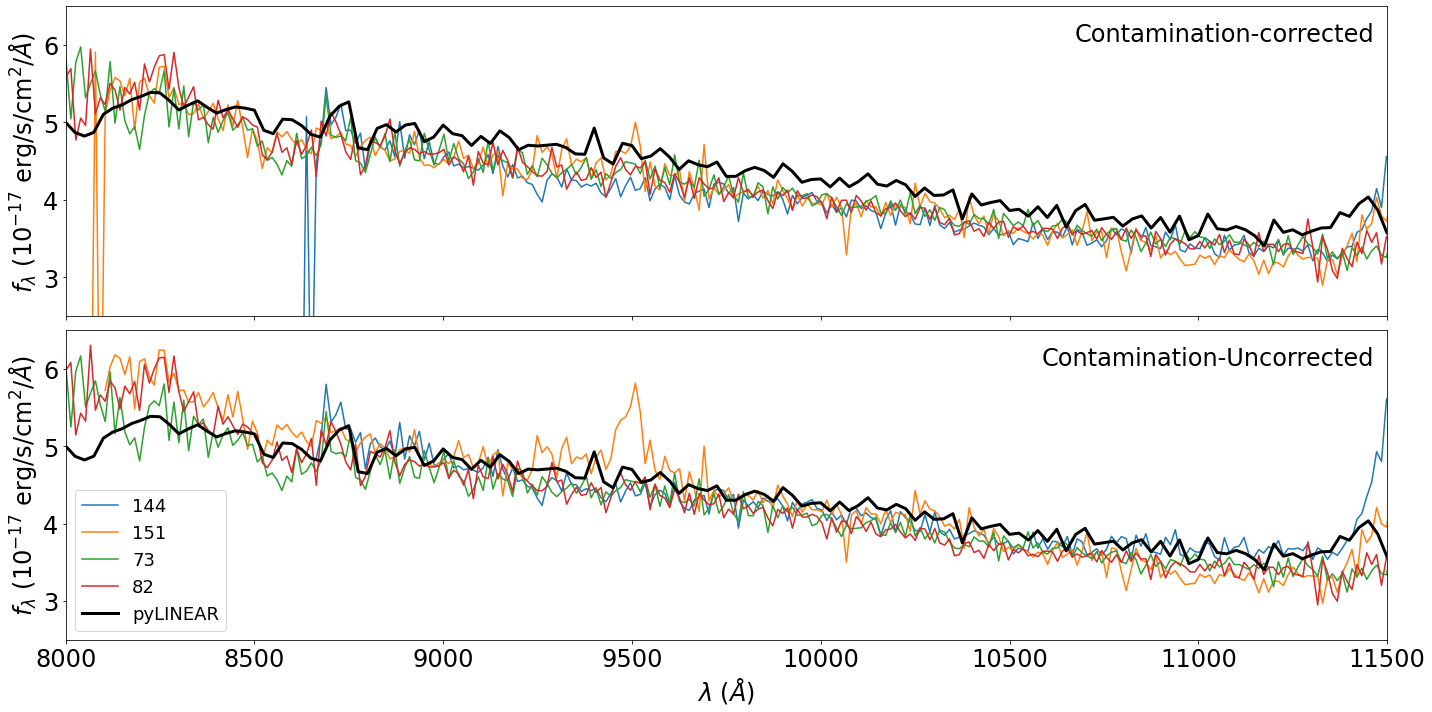

In [6]:
segid = 2679

# set the plot ranges.  In the previous examples, we got the x-range from the 
# extraction ranges. Now, we know the issues with that, so let's just clamp in to the 
# region of good throughput for the G102 grism
xrange = (8000,11500)
yrange = (2.5,6.5)

# read the FIGS data for each orient separately
#figs=fits.getdata('GS1_2679_G102.comb.fits',ext=1)
figs2=fits.getdata('GS1_G102_2679_53.15835998_-27.79492102_144.fits',ext=1)
figs3=fits.getdata('GS1_G102_2679_53.15835998_-27.79492102_151.fits',ext=1)
figs4=fits.getdata('GS1_G102_2679_53.15835998_-27.79492102_73.fits',ext=1)
figs5=fits.getdata('GS1_G102_2679_53.15835998_-27.79492102_82.fits',ext=1)

# read our results from pyLINEAR
data = fits.getdata('figs_x1d.fits',('SOURCE',segid))

# create two plots, top & bottom.  The top panel will be looking at the 
# contamination-corrected FIGS data (which will not match our results --- see above).
# The bottom panel will be the FIGS uncorrected data (which will better match pyLINEAR)
fig,(top,bot) = plt.subplots(2,1,sharex=True,figsize=(20,10))
top.tick_params(axis='both', which='major', labelsize=24)
bot.tick_params(axis='both', which='major', labelsize=24)

# plot the contamination corrected FIGS data (will not match!)
top.plot(figs2['wavelength'],figs2['flxsum']/1e-17,label='144')
top.plot(figs3['wavelength'],figs3['flxsum']/1e-17,label='151')        
top.plot(figs4['wavelength'],figs4['flxsum']/1e-17,label='73')
top.plot(figs5['wavelength'],figs5['flxsum']/1e-17,label='82')

# overplot the pyLINEAR result as black
top.plot(data['wavelength'],data['flam'],label='pyLINEAR',color='black',linewidth=3)
top.set_xlim(*xrange)
top.set_ylim(*yrange)
top.text(0.99,0.87,'Contamination-corrected',transform=top.transAxes,
         verticalalignment='bottom',horizontalalignment='right',fontsize=24)
top.set_ylabel(r'$f_\lambda$ ($10^{-17}$ erg/s/cm$^2$/$\AA$)',fontsize=24)


# plot the uncorrected data (ie put the correction back in)
bot.plot(figs2['wavelength'],(figs2['flxsum']+figs2['FLXCONTAM'])/1e-17,label='144')
bot.plot(figs3['wavelength'],(figs3['flxsum']+figs3['FLXCONTAM'])/1e-17,label='151')        
bot.plot(figs4['wavelength'],(figs4['flxsum']+figs4['FLXCONTAM'])/1e-17,label='73')
bot.plot(figs5['wavelength'],(figs5['flxsum']+figs5['FLXCONTAM'])/1e-17,label='82')

# overplot the pyLINEAR result as black
bot.plot(data['wavelength'],data['flam'],label='pyLINEAR',color='black',linewidth=3)
bot.set_xlim(*xrange)
bot.set_ylim(*yrange)
bot.text(0.99,0.87,'Contamination-Uncorrected',transform=bot.transAxes,
         verticalalignment='bottom',horizontalalignment='right',fontsize=24)
bot.legend(loc='lower left',fontsize=18)

bot.set_xlabel(r'$\lambda$ ($\AA$)',fontsize=24)
bot.set_ylabel(r'$f_\lambda$ ($10^{-17}$ erg/s/cm$^2$/$\AA$)',fontsize=24)

# reduce the space in the plots
plt.tight_layout()

Notice in the top panel (**contamination corrected**), the FIGS spectra (colored lines) all relatively well (the blue/orange lines that go to zero are where the given orient had no data, hence the measured spectrum was zero).  However the FIGS spectra do not match our ```pyLINEAR``` result, which is what was stated above.  Some features (e.g. emission-line feature at ~8750 A) are consistent between all data, including our ```pyLINEAR``` results.

The bottom panel, where we put back in the contamination correction back in.  Therefore  the colored lines, which have different contamination each, no longer match up --- most noticably in the orange line around 9500 A.    Also, since 3 of the orients (ie. 75% of the data) are inconsistent with that peak, ```pyLINEAR``` does not show any effect of it. Finally, our result with ```pyLINEAR``` is roughly the middle of the **uncorrected** FIGS data, which makes sense.

Since the contamination (~ 0.2x10^-17 erg/s/cm2/A) approximately 1/10th this galaxy's signal (~ 4x10^-17 erg/s/cm2/A), the source that is providing this contamination is likely around ```19-2.5*np.log10(0.1)=21.5``` mag.  

It is left as an exercise to the Reader to lower the ```maglim``` to account for this contamination, **however you will need to use the full segmentation map: ```GS1_-35_seg_ref.fits``` not the restricted one we used above.**

Text(0, 0.5, '$f_\\lambda$ ($10^{-17}$ erg/s/cm$^2$/$\\AA$)')

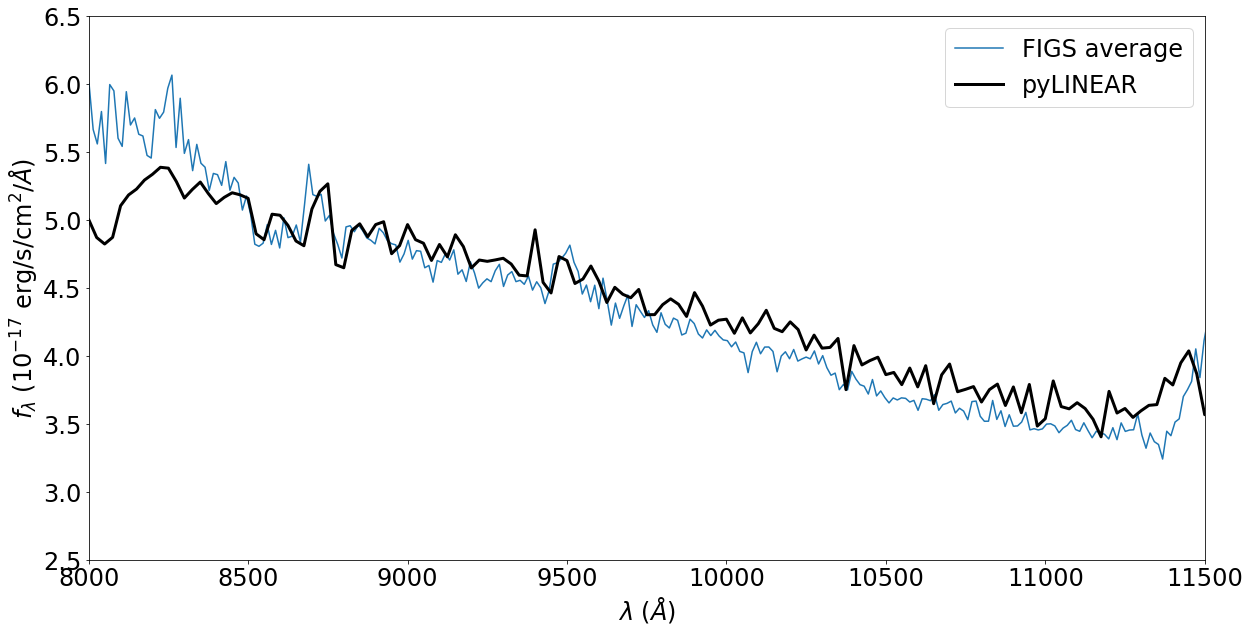

In [7]:
# average the uncorrected 
ave=np.zeros_like(figs2['flxsum'])
for i in range(len(figs2['flxsum'])):
    y=[figs2['flxsum'][i]+figs2['FLXCONTAM'][i],figs3['flxsum'][i]+figs3['FLXCONTAM'][i],figs4['flxsum'][i]+figs4['FLXCONTAM'][i],figs5['flxsum'][i]+figs5['FLXCONTAM'][i]]

    if np.isnan(y).all():
        ave[i]=0.
    else:
        ave[i]=np.nanmean(y)

fig,(axis) = plt.subplots(1,1,sharex=True,figsize=(20,10))
axis.tick_params(axis='both', which='major', labelsize=24)


axis.plot(figs2['wavelength'],ave/1e-17,label='FIGS average')
axis.plot(data['wavelength'],data['flam'],label='pyLINEAR',color='black',linewidth=3)
axis.set_xlim(*xrange)
axis.set_ylim(*yrange)
axis.legend(fontsize=24)
axis.set_xlabel(r'$\lambda$ ($\AA$)',fontsize=24)
axis.set_ylabel(r'$f_\lambda$ ($10^{-17}$ erg/s/cm$^2$/$\AA$)',fontsize=24)

## Command-Line Interface

Assuming that one can create the ```obslst``` and ```imglst``` files, then the extraction of the spectra (the bulk of this notebook) can be executed with a single call with the CLI:
 

```
prompt> pylinear --extract --segfile GS1_-35_seg_new.fits --obslst obs_figs.lst --imglst flt_figs.lst --beam +1 --mskbeams +2 --path tables_figs --method golden --logdamp -4,-1,0.1 --maglim 19. --root figs --remake False 
```

The variables are probably familiar at this point, but the ```--extract``` key can be shortened to ```-e``` tells ```pylinear``` that this is a simple extraction.